In [ ]:
import json
import os
import random
import urllib.request
from collections import defaultdict
from copy import deepcopy
from statistics import mean, stdev
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from PIL import Image
from torchvision import transforms, datasets
# from torchvision.datasets import CIFAR100, SVHN
import torchmetrics
from tqdm.auto import tqdm

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Import tensorboard
%load_ext tensorboard

# Setting the seed
L.seed_everything(42)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


Device: cpu


<Figure size 640x480 with 0 Axes>

In [ ]:
!pip install lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/MetaLearning/")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.', train=True, transform=transform_train, download=True)

#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.', train=True, transform=transform_val, download=True)

100%|██████████| 170498071/170498071 [01:01<00:00, 2772887.81it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms


for seed in range(1, 5):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128,
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128,
                                           shuffle=False) 

Num Samples For Training 50 Num Samples For Val 400
Num Samples For Training 50 Num Samples For Val 400
Num Samples For Training 50 Num Samples For Val 400
Num Samples For Training 50 Num Samples For Val 400


In [ ]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(
        growth_rate=32,
        block_config=(6, 6, 6, 6),
        bn_size=2,
        num_init_features=64,
        num_classes=output_size,  # Output dimensionality
    )
    return convnet

In [ ]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

In [ ]:
class ProtoNet(L.LightningModule):
    def __init__(self, proto_dim, lr):
        """Inputs.

        proto_dim - Dimensionality of prototype feature space
        lr - Learning rate of Adam optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.train_loss_array = []
        self.train_acc_array = []

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)

        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)
        self.accuracy(preds, labels)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.calculate_loss(batch, mode="train")
        self.train_acc_array.append(acc)
        self.train_loss_array.append(loss.item())
        self.log('train_acc', acc, on_epoch=True)
        self.log('train_loss', loss, on_epoch=True)
        return loss
  
    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics['train_acc']
        train_loss = self.trainer.callback_metrics['train_loss']
        # print(f'Training accuracy: {train_acc:.4f}')

    def validation_step(self, batch, batch_idx):
        self.calculate_loss(batch, mode="val")

In [ ]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
        accelerator="auto",
        devices=1,
        max_epochs=100,
        callbacks=[
            ModelCheckpoint(save_weights_only=False, mode="max"), #monitor="val_acc"
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=True,
    )


    L.seed_everything(42)  # To be reproducable
    model = model_class(**kwargs)
    trainer.fit(model, train_loader, val_dataloaders=None)
    print(trainer.logged_metrics)
    train_acc_array = np.array(model.train_acc_array)
    train_loss_array = model.train_loss_array
    print(train_loss_array)
    model = model_class.load_from_checkpoint(
        trainer.checkpoint_callback.best_model_path
    ) 

    return model, train_acc_array, train_loss_array

In [ ]:
protonet_model, accs, losses = train_model(
    ProtoNet, proto_dim=64, lr=0.001, train_loader=train_loader, val_loader=val_loader
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | model    | DenseNet           | 962 K 
1 | accuracy | MulticlassAccuracy | 0     
---------------------

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


{'train_acc_step': tensor(1.), 'train_loss_step': tensor(6.5607e-06), 'train_acc_epoch': tensor(1.), 'train_loss_epoch': tensor(6.5607e-06)}
[0.9427873492240906, 0.40009745955467224, 0.30906498432159424, 0.23655900359153748, 0.16157014667987823, 0.0773472934961319, 0.07708445191383362, 0.24796392023563385, 0.022463025525212288, 0.005579774267971516, 0.071809321641922, 0.09953673183917999, 0.0005186538910493255, 0.00034083882928825915, 0.006869092583656311, 0.0005431079189293087, 0.0005645580822601914, 0.03155390918254852, 0.01536437589675188, 0.00011755459127016366, 0.02407516911625862, 3.6525116229313426e-06, 0.0009555089636705816, 2.985803257615771e-05, 0.0004041416977997869, 0.0006830758065916598, 7.376039775408572e-06, 1.2177222743048333e-05, 0.01300771813839674, 4.4488631829153746e-05, 3.919527898688102e-06, 3.623946440711734e-07, 0.1477506160736084, 4.79672962683253e-06, 1.327888821833767e-05, 0.012289166450500488, 0.09979598224163055, 0.006058007013052702, 0.00011158882989548147

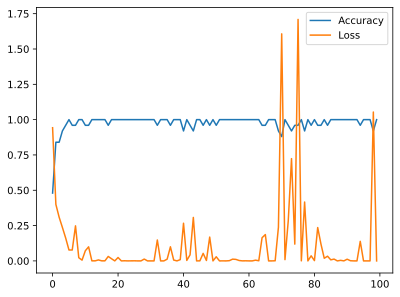

In [ ]:
plt.plot(range(len(accs)), accs, label='Accuracy')
plt.plot(range(len(losses)), losses, label='Loss')
plt.legend()
plt.show()

In [ ]:
# model = ProtoNet.load_from_checkpoint("./saved_models/MetaLearning/ProtoNet/lightning_logs/version_1/checkpoints/epoch=19-step=20.ckpt")

In [ ]:
@torch.no_grad()
def test_proto_net(model, dataloader, data_feats=None, k_shot=4):
    """Inputs.

    model - ProtoNet model
    dataset - The dataset on which the test should be performed.
              Should be instance of ImageDataset
    data_feats - The encoded features of all images in the dataset.
                 If None, they will be newly calculated, and returned
                 for later usage.
    k_shot - Number of examples per class in the support set.
    """
    model = model.to(device)
    model.eval()
    # num_classes = dataset.targets.unique().shape[0]
    num_classes = 2
    # exmps_per_class = dataset.targets.shape[0] // num_classes  # We assume uniform example distribution here
    exmps_per_class = 200

    # The encoder network remains unchanged across k-shot settings. Hence, we only need
    # to extract the features for all images once.
    if data_feats is None:
        # Dataset preparation
        # dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        # Select support set and calculate prototypes
        k_img_feats = img_features[k_idx : k_idx + k_shot].flatten(0, 1)
        k_targets = img_targets[k_idx : k_idx + k_shot].flatten(0, 1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        batch_acc_arr = []
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats = img_features[e_idx : e_idx + k_shot].flatten(0, 1)
            e_targets = img_targets[e_idx : e_idx + k_shot].flatten(0, 1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
            batch_acc_arr.append(acc.item())
        batch_acc = mean(batch_acc_arr)
        accuracies.append(batch_acc)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

Results for epoch = 100 and learning rate = 0.01

In [ ]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32, 64]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, val_loader, data_feats=data_feats, k_shot=k)
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protonet_accuracies[k][0], 100 * protonet_accuracies[k][1])
    )

Extracting image features:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy for k=2: 55.04% (+-9.61%)


Evaluating prototype classification:   0%|          | 0/50 [00:00<?, ?it/s]

Accuracy for k=4: 56.59% (+-8.57%)


Evaluating prototype classification:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy for k=8: 59.38% (+-7.28%)


Evaluating prototype classification:   0%|          | 0/13 [00:00<?, ?it/s]

Accuracy for k=16: 62.22% (+-1.10%)


Evaluating prototype classification:   0%|          | 0/7 [00:00<?, ?it/s]

Accuracy for k=32: 62.02% (+-1.53%)


Evaluating prototype classification:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy for k=64: 63.02% (+-2.76%)


Results for epoch = 100 and learning rate = 0.001

In [ ]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32, 64]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, val_loader, data_feats=data_feats, k_shot=k)
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protonet_accuracies[k][0], 100 * protonet_accuracies[k][1])
    )

Extracting image features:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy for k=2: 63.50% (+-12.33%)


Evaluating prototype classification:   0%|          | 0/50 [00:00<?, ?it/s]

Accuracy for k=4: 67.23% (+-8.53%)


Evaluating prototype classification:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy for k=8: 68.36% (+-9.17%)


Evaluating prototype classification:   0%|          | 0/13 [00:00<?, ?it/s]

Accuracy for k=16: 71.21% (+-1.12%)


Evaluating prototype classification:   0%|          | 0/7 [00:00<?, ?it/s]

Accuracy for k=32: 72.62% (+-1.76%)


Evaluating prototype classification:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy for k=64: 73.57% (+-2.47%)


Results for epoch = 100 and learning rate = 0.0002

In [ ]:
# epoch = 100 lr = 0.0002
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32, 64, 75]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, val_loader, data_feats=data_feats, k_shot=k)
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protonet_accuracies[k][0], 100 * protonet_accuracies[k][1])
    )

Extracting image features:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy for k=2: 54.63% (+-5.68%)


Evaluating prototype classification:   0%|          | 0/50 [00:00<?, ?it/s]

Accuracy for k=4: 56.22% (+-5.62%)


Evaluating prototype classification:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy for k=8: 58.97% (+-4.23%)


Evaluating prototype classification:   0%|          | 0/13 [00:00<?, ?it/s]

Accuracy for k=16: 63.22% (+-3.17%)


Evaluating prototype classification:   0%|          | 0/7 [00:00<?, ?it/s]

Accuracy for k=32: 66.67% (+-1.80%)


Evaluating prototype classification:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy for k=64: 70.70% (+-3.52%)


Evaluating prototype classification:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy for k=75: 65.89% (+-2.70%)
